# Bellmann Ford's Algorithm

Bellmann Ford algorithm computes the shortest path from the source node to the remaining nodes in the graph. The algorithm has a slower performance than the Dijkstra's algorithm for computing the shortest path, however, the Bellmann Ford algorithm is more verstaile since it can compute the shortest path in graphs which have some negative weighted edges.

In the context of routing, [Distance-Vector Routing algorithms](https://en.wikipedia.org/wiki/Distance-vector_routing_protocol) like the [Routing Information Protocol](https://en.wikipedia.org/wiki/Routing_Information_Protocol) uses a variant of the Bellmann-Ford algorithm where the number hops is the routing parameter. In practice, the Bellmann-Ford algorithm is run in a distributed setting, since it is run on individual nodes on the network.   

In this notebook, we introduce the idea of the Bellmann-Ford algorithm and its implementations on both a directed and undirected weighted graphs.

### Table of Contents
1. [Building the graph](#graph1)
2. [About the algorithm](#algorithm)
3. [Implementation on undirected, weighted graph](#implementation)
4. [Detecting Negative-weight cycles](#negativeCycles)
5. [Computing shortest path on graphs with negative edges](#comparison)
6. [Proof of Correctness](#proof)
7. [References](#references)

## Fetching required modules

Before, we get started lets import code modules which would make us focus on understanding the Bellmann-Ford's algorithm.

In [1]:
import os, sys
from os.path import dirname, join, abspath
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, abspath(join(dirname("modules"), '..')))
from modules.create_graph import *
from modules.visualize_graph import *

<a class="anchor" id="graph1"></a>
## Building the graph

To establish the implementation of the Bellmann-Ford's algorithm, we create a weighted, undirected graph which is the same graph used in the [previous notebook](./1_dijkstra.ipynb) for Dijkstra's algorithm.

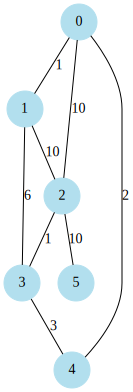

In [2]:
a = Node()
b = Node()
c = Node()
d = Node()
e = Node()
f = Node()
g = Node()
graphs = Graph.createGraph([a, b, c, d, e, f], directed=False)


graphs.add_Edge(a,b,1)
graphs.add_Edge(a,c,10)
graphs.add_Edge(a,e,2)
graphs.add_Edge(b,c,10)
graphs.add_Edge(b,d,6)
graphs.add_Edge(c,d,1)
graphs.add_Edge(c,f,10)
graphs.add_Edge(d,e,3)

visualizeGraph(graphs, "bellmanFord")

<a class="anchor" id="algorithm"></a>
## About the algorithm

### Psuedo code
<pre>1 <b>function</b> BellmanFord(<i>list</i> graph, <i>node</i> source)
2   <b>for each</b> vertex v <b>in</b> graph:
3       distance[v]&nbsp;:= <b>INFINITY</b>             
4       predecessor[v]&nbsp;:= <b>null</b>         
5   
6   distance[source]&nbsp;:= 0              
7 
8
9   <b>for</b> i <b>from</b> 1 <b>to</b> size(vertices)-1: //just |V|-1 repetitions; i is never referenced
10       <b>for each</b> edge (u, v) <b>with</b> weight w <b>in</b> edges:
11           <b>if</b> distance[u] + w &lt; distance[v]:
12               distance[v]&nbsp;:= distance[u] + w
13               predecessor[v]&nbsp;:= u
14               
15   <b>for each</b> edge (u, v) <b>with</b> weight w <b>in</b> edges:
16       <b>if</b> distance[u] + w &lt; distance[v]:
17           <b>error</b> "Graph contains a negative-weight cycle"
18           <b>break</b>
19
20   <b>return</b> distance[], predecessor[]
</pre>

<a class="anchor" id="implementation"></a>
## Implementing Bellmann Ford's algorithm

In [8]:
def bellmannFord(graph, sourceNode, targetNode):
    sourceNodeIndex = graph.get_nodeIndex(sourceNode)
    targetNodeIndex = graph.get_nodeIndex(targetNode)
    nodeList = graph.get_allNodes()
    
    # Make an array keeping track of distance from node to any node
    # in self.nodes. Initialize to infinity for all nodes but the 
    # starting node, keep track of "path" which relates to distance.
    # Index 0 = distance, index 1 = previous_hops
    dist = [None] * len(nodeList)
    previous = [None] * len(nodeList)
    for i in range(len(dist)):
        dist[i] = float("inf")
        previous[i] = []
        
    dist[sourceNodeIndex] = 0

    
    # Step 2: Relax all edges |V| - 1 times. A simple shortest  
    # path from src to any other vertex can have at-most |V| - 1  
    # edges 
    for i in range(len(nodeList) - 1):
        # update dist value and parent index of adjacent values of picked vertex.
        # consider those which are still in queue.
        for u, v, w in graph.get_allEdges():
            
            if dist[u]!= float("Inf") and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                
                previous[v] = list(previous[u])
                previous[v].append(u)      
                
                
    # check for negative weight cycles. If path obtained from above step (shortest distances)
    # is shorter, there's a cycle. So quit.
    for u, v, w in graph.get_allEdges():
        if dist[u] != float("Inf") and dist[u] + w < dist[v]:
            print("Negative Cycles Detected at %d" %v)
            return dist[targetNodeIndex], ["Negative Cycle Detected"]
        
    #before returning add the targetNodeIndex to visited Nodes
    previous[targetNodeIndex].append(targetNodeIndex)
    return dist[targetNodeIndex], previous[targetNodeIndex]

Total distance to sourceNode 0 from targetNode 5 is 20


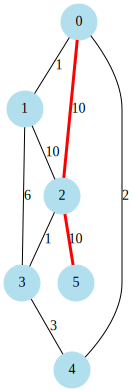

In [10]:
sourceNode = a
targetNode = f

distances, previousNodes = bellmannFord(graphs, sourceNode, targetNode)

path = None
if distances != float("inf"):
    print("Total distance to sourceNode %d from targetNode %d is %d" % (graphs.get_nodeIndex(sourceNode),  graphs.get_nodeIndex(targetNode), distances))
    edgelist = []
    for i in range(len(previousNodes)):
                try:
                    wt = graphs.get_edgeWeight(previousNodes[i],previousNodes[i+1])
                    edgelist.append((previousNodes[i],previousNodes[i+1], wt))

                except IndexError:
                    break

    path = displayPath(edgelist, "bellmanFord")
else:
    print("Total distance to sourceNode %d from targetNode %d is %f" % (graphs.get_nodeIndex(sourceNode),  graphs.get_nodeIndex(targetNode), distances))

path

<a class="anchor" id="comparison"></a>
## Computing the shortest path in a graph with negative edge weights

Now, we are interested to compare the Dijsktra's shortest path algorithm with the Bellmann Ford algorithm to find the difference between the two algorithms. For nodes which have non-negative edges, we find Dijkstra to be a faster and more efficient solution. However, when there are some edges that have negative weights, Dijkstra's algorithm is not able to correctly compute the shortest path. This is due to the greedy-decision making condition of selecting the node with the minimum distance. Bellmann-Ford on the other hand is able to handle the negative weights better.

In [11]:
def dijkstra(graph, sourceNode, targetNode):
    sourceNodeIndex = graph.get_nodeIndex(sourceNode)
    targetNodeIndex = graph.get_nodeIndex(targetNode)
    nodeList = graph.get_allNodes()

    # Make an array keeping track of distance from node to any node
    # in self.nodes. Initialize to infinity for all nodes but the 
    # starting node, keep track of "path" which relates to distance.
    # Index 0 = distance, index 1 = previous_hops
    dist = [None] * len(nodeList)
    previous = [None] * len(nodeList)
    for i in range(len(dist)):
        dist[i] = float("inf")
        previous[i] = [sourceNodeIndex]

    
    dist[sourceNodeIndex] = 0
 
    # Queue of all nodes in the graph
    # Note the integers in the queue correspond to indices of node
    # locations in the self.nodes array
    queue = [i for i in range(len(nodeList))]
    
    # Set of numbers seen so far
    seen = set()
    while len(queue) > 0:
        # Get node in queue that has not yet been seen
        # that has smallest distance to starting node
        min_dist = float("inf")
        min_node = None
        for n in queue: 
            if dist[n] < min_dist and n not in seen:
                min_dist = dist[n]
                min_node = n
        try:
            # Add min distance node to seen, remove from queue
            queue.remove(min_node)
            seen.add(min_node)


            # Get all next hops -> all shortest paths
            connections = graph.get_connections(min_node)

            # For each connection, update its path and total distance from 
            # starting node if the total distance is less than the current distance
            # in dist array

            for (node, weight) in connections.items(): 

                tot_dist = weight + min_dist

                if tot_dist < dist[node]:
                    #if less, print the update
                    dist[node] = tot_dist
                    previous[node] = list(previous[min_node])
                    previous[node].append(node)
                    
                    if node != targetNodeIndex :
                        continue
                    else:
                        return dist[node], previous[node]
        except ValueError:
                print ("Distance to node %d is %d" %(targetNodeIndex, sys.maxsize))
                return None, None

In [12]:
a = Node()
b = Node()
c = Node()
d = Node()
e = Node()
f = Node()

compare_graph = Graph.createGraph([a, b, c, d, e, f], directed=False)



compare_graph.add_Edge(a,b,5)
compare_graph.add_Edge(b,c,10)
compare_graph.add_Edge(b,d,5)
compare_graph.add_Edge(c,e,-20)
compare_graph.add_Edge(e,d,10)
compare_graph.add_Edge(d,f,5)


visualizeGraph(compare_graph, "bellmanFord_compare")
visualizeGraph(compare_graph, "Dijkstra_compare")

adjacentMatrix = compare_graph.get_adjMatrix()

sourceNode = a
targetNode = f

distances_Dijks, previousNodes_Dijks = dijkstra(compare_graph, sourceNode, targetNode)
distances_BF, previousNodes_BF = bellmannFord(compare_graph, sourceNode, targetNode)


print ("\t\t  | Dijkstra\t| Bellmann-Ford")
print ("Distance Computed | %d\t\t| %d" % (distances_Dijks, distances_BF))
print ("Previous Nodes    | %s| %s" % (previousNodes_Dijks, previousNodes_BF))

edgelistBF = []
for i in range(len(previousNodes_BF)):
            try:
                wt = graphs.get_edgeWeight(previousNodes_BF[i],previousNodes_BF[i+1])
                edgelistBF.append((previousNodes_BF[i],previousNodes_BF[i+1], wt))

            except IndexError:
                break
edgelistDij = []
for i in range(len(previousNodes_Dijks)):
            try:
                wt = graphs.get_edgeWeight(previousNodes_Dijks[i],previousNodes_Dijks[i+1])
                edgelistDij.append((previousNodes_Dijks[i],previousNodes_Dijks[i+1], wt))

            except IndexError:
                break
                

		  | Dijkstra	| Bellmann-Ford
Distance Computed | 15		| 10
Previous Nodes    | [0, 1, 3, 5]| [0, 1, 2, 4, 3, 5]


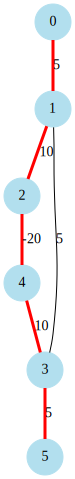

In [13]:
displayPath(edgelistBF, "bellmanFord_compare")

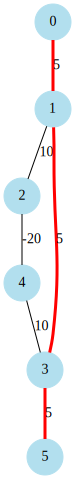

In [14]:
displayPath(edgelistDij, "Dijkstra_compare")

<a class="anchor" id="negativeCycles"></a>
## Detecting Negative Weights Cycles

A cycle is considered a negative weight cycle when the sum of all its edges are negative. If a negative cycle exisits in the graph that is reachable from the source node, then an additional walk over the negative cycle is required to get the shortest path. Bellmann-Ford algorithm can detect negative weight cycles which makes it useful to determine the presence of a shortest path in the graph.



In [15]:
a = Node()
b = Node()
c = Node()
d = Node()
e = Node()
f = Node()

negative_wt_graphs = Graph.createGraph([a, b, c, d, e, f], directed=True)



negative_wt_graphs.add_Edge(a,b,5)
negative_wt_graphs.add_Edge(b,c,10)
negative_wt_graphs.add_Edge(b,d,5)
negative_wt_graphs.add_Edge(c,e,-20)
negative_wt_graphs.add_Edge(e,d,10)
negative_wt_graphs.add_Edge(d,f,5)
negative_wt_graphs.add_Edge(e,b,-5)




visualizeGraph(negative_wt_graphs, "neg_bellmanFord")
sourceNode = a
targetNode = f

bellmannFord(negative_wt_graphs, sourceNode, targetNode)

Negative Cycles Detected at 2


(-50, ['Negative Cycle Detected'])

<a class="anchor" id="proof"></a>
## Proof of Correctness

Let G(V,E) be a weighted, directed graph where $V$ represents the set of all nodes and $E$ represents the set of all edges in the graph. $dist[u]$ represents the distance computed by the algorithm and $\delta(s,u)$ represents the actual shortest distance existing from the source node $s$ to the target node $u$, based on [1].


If graph G, contains no negative weight cycles that are reachable from the source node, the Bellamm Ford Algorithm returns TRUE and $d[v] = \delta(s, v)\; \forall v \in V$ and the subgraph of predecessors $G_{\pi}$ is a shortest path tree rooted at $s$. If graph G contains a negative weight cycle reachable from the source node, the algorithm returns FALSE.

*To Prove:* $d[u] = \delta(s,u)\; \forall u \in V$ such that the graph contains no negative weight cycles.

Let us consider that node $v$ on the graph that is reachable from the source node $s$, through a path 'p' such that $p = \{v_{0}, v_{1},....., v_{k}\} \text{where} v_{0} = s \text{and} v_{k} = v$. Let path 'p' be the shortest path from the source node $s$ to node $v$ which means at most it has $|V| - 1$ edges as part of the path, thus, $k \leq |V| - 1$.

For each node v in $|V| - 1$ iterations, we perform the distance computations for the $|V| - 1$ edges as,
$$
\text{if } d[v] > d[u] + edge\_length(u,v):\\
    d[v] = d[u] + edge\_length(u,v)\\
    previous[v] = u
$$

For each iteration $i$ of the algorithm, the distance computed for a node $v_{i}$ on the path 'p', 
$d[v_{i}] = \delta(s, v_{i})$. The equality holds true, since we consider 'p' as the shortest path, and the distance to each edge on the path from the source node is computed in the order $(v_{0}, v_{1}), (v_{1}, v_{2}), ......., (v_{k-1}, v_{k})$ where $v_{0} = s$, then $d[v_{k}] = \delta(s, v_{k})$. This property holds regardless for any other computation for $d[v_{k}]$ which may occur, even if they are intermixed with the distance computation of other edges in 'p'.

Thus, if a node $v \in V$ is not reachable from the source, there would exists no path from the source $s$ to node $v$ and the computed distance will be  $d[v] = \infty = \delta(s, v)$. 

Once, we establish $d[v] = \delta(s, v)\; \forall v \in V$; we have the shortest path tree $G{\pi}$ from the source node $s$ containing all the predecessor nodes. Now, we use these claims to prove that the Bellmann Ford algorithm returns TRUE.

At the termination, we have for all (u,v) in E,
$$
d[v] = \delta(s, v)\\
    \leq d[u] + edge\_length(u,v) \\
    = d[u] + edge\_length(u,v)
$$

In none of the steps, where $d[v]$ is computed can the algorithm return FALSE. Thus, the algorithm always returns TRUE.

Now, if we consider that graph G contains negative weight cycles that is reachable from the source $s$ defined as $c = \{v_{0}, v_{1},....., v_{k}\} \text{where } v_{0} = s$; then,

$$
\sum\limits_{i=1}^k edge\_length(v_{i-1}, v_{i}) <0   \text{ (Eq.1.)}
$$

Assume that the Bellmann Ford algorithm returns TRUE, for the purpose of contradiction. Then, $d[ v_{i}] \leq d[v_{i-1}] + edge\_length(v_{i-1}, v_{i})$ for $i = 1, 2, ......, k$.

Summing both sides of the above inequality for cycle $c$, we get,
$$\sum d[ v_{i}] \leq \sum d[v_{i-1}] + edge\_length(v_{i-1}, v_{i}) \\
\sum d[ v_{i}] \leq \sum d[v_{i-1}] + \sum edge\_length(v_{i-1}, v_{i})$$

In cycle $c$ since, $v_{0} = v_{k}$, each node is visited only once in each summation namely $\sum\limits_{i=1}^k d[v_{i}]$ and $\sum\limits_{i=1}^k d[v_{i-1}]$, which means 

$$\sum\limits_{i=1}^k d[v_{i}] = \sum\limits_{i=1}^k d[v_{i-1}]$$

Moreover, the Bellmann Ford algorithm finds a path 'p' from the source node $s$ to the target node $u$ on G with non-negative weight cycles only when the algorithm terminates with $d[v] < \infty$ which implies that $d[v]$ is a finite measure and that,
$$
0 \leq \sum\limits_{i=1}^k edge\_length(v_{i-1}, v_{i})  \text{ (Eq.2.)}
$$

We observe that (Eq.2.) contradicts (Eq.1.) and so, Bellmann Ford algorithm returns TRUE if and only if the graph contains a non-negative cycle that is reachable from the source node $s$.

<a class="anchor" id="references"></a>
## Reference

- [1] Leiserson, Charles Eric, Ronald L. Rivest, Thomas H. Cormen, and Clifford Stein. Introduction to algorithms. Chapter 24. Vol. 6. Cambridge, MA: MIT press, 2001.
- [2] Bellmann-Ford Algorithm on [Wikipedia](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm)
- [3] Implementation of Belmman-Ford inspired form [Geeks for Geeks](https://www.geeksforgeeks.org/bellman-ford-algorithm-dp-23/)